## Interpretability

In [1]:
# stdlib
import copy
from pathlib import Path
import warnings

# third party
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# autoprognosis absolute
from autoprognosis.plugins.explainers import Explainers
from autoprognosis.plugins.prediction import Predictions
from autoprognosis.utils.serialization import load_model_from_file, save_model_to_file
from autoprognosis.utils.tester import evaluate_estimator

warnings.filterwarnings("ignore")


models_path = Path("./workspace")
print(models_path.absolute())
models_path.mkdir(parents=True, exist_ok=True)

/home/bcebere/code/vds/autoprognosis/tutorials/plugins/workspace


In [2]:
Explainers().list()

[]

In [3]:
Predictions().list()

[]

In [4]:
models = {
    "lime": {},
    "shap_permutation_sampler": {},
    "kernel_shap": {},
    "invase": {},
}

## Dataset

In [5]:
# stdlib
import copy

# third party
import pandas as pd
from sklearn.model_selection import train_test_split

# Wine Quality Data Set
df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv",
    sep=";",
)


last_col = df.columns[-1]

y = df[last_col]
mapped_labels = sorted(y.unique())
mapping = {}
for idx, label in enumerate(mapped_labels):
    mapping[label] = idx
y = y.map(mapping)

X = df.drop(columns=[last_col])

X_train, X_test, y_train, y_test = train_test_split(X, y)

test_set = X_test[:10]
columns = X.columns

X

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4
...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2


## XGBoost

In [6]:
# Test sanity

model = Predictions(category="classifier").get("xgboost")

evaluate_estimator(model, X_train, y_train, n_folds=2)["str"]

{'aucroc': '0.879 +/- 0.001'}

importance 
 free sulfur dioxide <= 7.00              0.003775
pH > 3.41                                0.002668
citric acid <= 0.09                      0.002195
chlorides <= 0.07                        0.001664
alcohol > 11.15                          0.001009
residual sugar <= 1.90                   0.000773
sulphates > 0.73                        -0.000752
21.50 < total sulfur dioxide <= 38.00   -0.000647
density <= 1.00                         -0.000541
0.52 < volatile acidity <= 0.64          0.000246
Name: 0, dtype: float64


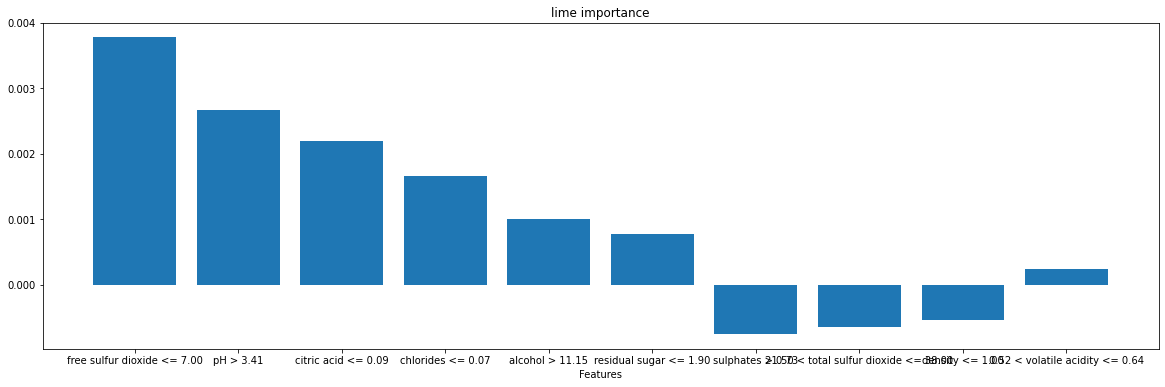

In [9]:
# lime


def get_lime(category, model_name):
    model = Predictions(category).get(model_name)
    model_file = models_path / "lime.p"

    if not model_file.exists():
        exp = Explainers().get(
            "lime",
            copy.deepcopy(model),
            X_train,
            y_train,
            feature_names=columns,
            task_type="classification",
        )
        save_model_to_file(model_file, exp)
    else:
        exp = load_model_from_file(model_file)

    return exp


def explain_lime(test_set, category, model_name):
    exp = get_lime(category, model_name)
    output = exp.explain(test_set).squeeze()
    print("importance \n", output)
    exp.plot(output, feature_names=list(output.index))


explain_lime(test_set.head(1), "classifier", "xgboost")

  0%|          | 0/10 [00:00<?, ?it/s]

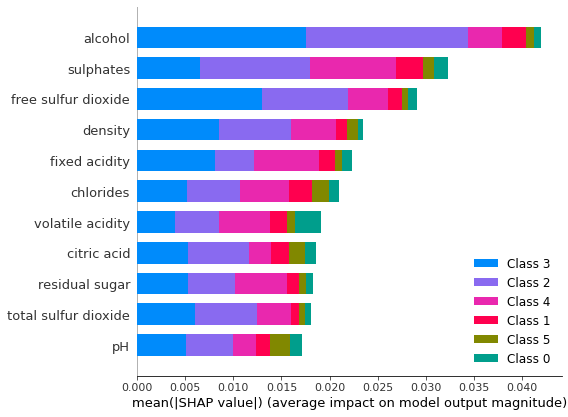

In [11]:
# kernel_shap
def get_kernel_shap(category, model_name):
    model = Predictions(category).get(model_name)
    model_file = models_path / "kernel_shap.p"

    if not model_file.exists():
        exp = Explainers().get(
            "kernel_shap",
            copy.deepcopy(model),
            X_train,
            y_train,
            feature_names=columns,
            task_type="classification",
        )
        save_model_to_file(model_file, exp)
    else:
        exp = load_model_from_file(model_file)

    return exp


def explain_kernel_shap(test_set, category, model_name):
    exp = get_kernel_shap(category, model_name)
    exp.plot(test_set)


explain_kernel_shap(test_set, "classifier", "xgboost")

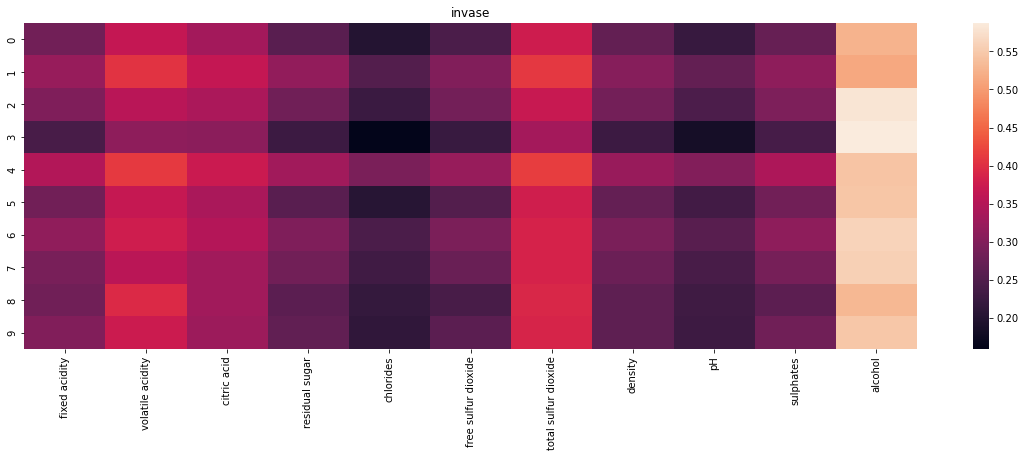

In [12]:
# invase
def get_invase(category, model_name):
    model = Predictions(category).get(model_name)
    model_file = models_path / "invase.p"

    if not model_file.exists():
        exp = Explainers().get(
            "invase",
            copy.deepcopy(model),
            X_train,
            y_train,
            feature_names=columns,
            n_folds=1,
            n_epoch=200,
            task_type="classification",
        )
        save_model_to_file(model_file, exp)
    else:
        exp = load_model_from_file(model_file)

    return exp


def explain_invase(test_set, category, model_name):
    exp = get_invase(category, model_name)
    output = exp.explain(test_set)

    exp.plot(output)


explain_invase(test_set, "classifier", "xgboost")

# Congratulations!

Congratulations on completing this notebook tutorial! If you enjoyed this and would like to join the movement towards Machine learning and AI for medicine, you can do so in the following ways!

### Star AutoPrognosis on GitHub

The easiest way to help our community is just by starring the Repos! This helps raise awareness of the tools we're building.

- [Star AutoPrognosis](https://github.com/vanderschaarlab/autoprognosis)
- [Star HyperImpute](https://github.com/vanderschaarlab/hyperimpute)
